In [1]:
!pip install japanize-matplotlib

In [1]:
import os
import zipfile
from glob import glob
from pathlib import Path
import math
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore')

from contextlib import contextmanager
from time import time

class Timer:
    """処理時間を表示するクラス
    with Timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)
    
    with Timer(prefix='fit fold={} '.format(i)):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)
    """
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

#最大表示列数の指定
pd.set_option('display.max_columns', 50)
#最大表示行数の指定
pd.set_option('display.max_rows', 50)

def seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
seed(42)

In [2]:
data_path = Path('../data')

In [3]:
# データの生成
# 物件価格 説明変数:居住面積
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[data['MSSubClass']==60][['GrLivArea']].values
Y = data[data['MSSubClass']==60][['SalePrice']].values
xLabel = '居住面積: x[平方フィート]'
yLabel = '物件価格: y[ドル]'

Text(0, 0.5, '物件価格: y[ドル]')

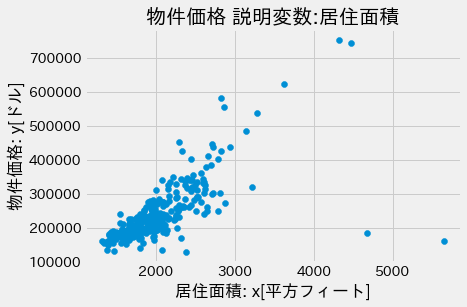

In [4]:
# データの可視化
plt.scatter(X, Y)
plt.title('物件価格 説明変数:居住面積')
plt.xlabel(xLabel)
plt.ylabel(yLabel)

In [5]:
# データを訓練と評価用に分割
dtrNum = int(len(X)*0.9)    # 学習データ数

# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

In [6]:
class linerRegression():
    """線形モデル"""
    def __init__(self, x, y):
        """
        args:
            x: 
                入力データ（データ数×次元数のnumpy.ndarray）
            y:
                出力データ（データ数×1のnumpy.ndarray）
        """
        # 訓練データの設定
        self.X = x
        self.Y = y

        self.dNum = x.shape[0]  # 訓練データ数
        self.xDim = x.shape[1]  # 入力の次元数
        
    def train(self):
        """
        最小二乗法を使用してモデルパラメータを最適化
        """
        # 行列Xに「1」の要素を追加
        Z = np.concatenate([self.X, np.ones([self.dNum, 1])], axis=1)

        # 分母の計算
        ZZ = 1/self.dNum * np.dot(Z.T,Z)

        # 分子の計算
        ZY = 1/self.dNum * np.dot(Z.T,self.Y)

        # パラメータvの最適化
        # v = np.matmal(np.linalg.inv(ZZ),ZY)
        # 擬似逆行列 (pseudo-inverse matrix)
        v = np.dot(np.linalg.pinv(ZZ),ZY)

        # パラメータw,bの決定
        self.w = v[:-1]
        self.b = v[-1]
    
    def trainRegularized(self,lamb=0.1):
        """
        L2ノルム正則化最小二乗法を用いてモデルパラメータを最適化
        
        args:
            lamb: 
                正則化の重み係数（実数スカラー）
        """
        # 行列Xに「1」の要素を追加
        Z = np.concatenate([self.X,np.ones([self.dNum,1])],axis=1)

        # 分母の計算
        ZZ = 1/self.dNum * np.matmul(Z.T,Z) + lamb * np.eye(self.xDim)

        # 分子の計算
        ZY = 1/self.dNum * np.dot(Z.T,self.Y)

        # パラメータvの最適化
        # v = np.dot(np.linalg.inv(ZZ),ZY)
        # 擬似逆行列 (pseudo-inverse matrix)
        v = np.dot(np.linalg.pinv(ZZ),ZY)

        # パラメータw,bの決定
        self.w = v[:-1]
        self.b = v[-1]
    
    def predict(self,x):
        """
        args:
            x: 
                入力データ（データ数×次元数のnumpy.ndarray）
        """
        return np.dot(x ,self.w[:len(x)].reshape(-1, 1)) + self.b

    def RMSE(self,X,Y):
        """
        平方平均二乗誤差（Root Mean Squared Error）
        
        args:
            X: 入力データ（データ数×次元数のnumpy.ndarray）
            Y: 出力データ（データ数×１のnumpy.ndarray）
        """
        return np.sqrt(np.mean(np.square(self.predict(X)-Y)))
        
    def R2(self,X,Y):
        """
        決定係数の計算
        
        args:
            X: 入力データ（データ数×次元数のnumpy.ndarray）
            Y: 出力データ（データ数×１のnumpy.ndarray）
        """
        return 1 - np.sum(np.square(self.predict(X)-Y))/np.sum(np.square(Y-np.mean(Y,axis=0)))
    
    def plotResult(self,X=[],Y=[],xLabel='',yLabel='',fName=''):
        """
        データと線形モデルのプロット
        
        args:
            X: 入力データ（データ数×次元数のnumpy.ndarray）
            Y: 出力データ（データ数×１のnumpy.ndarray）
            xLabel: x軸のラベル（文字列）
            yLabel: y軸のラベル（文字列）
            fName: 画像の保存先（文字列）
        """
        if X.shape[1] != 1: return
        
        fig = plt.figure(figsize=(8,5),dpi=100)
        
        # 線形モデルの直線の端点の座標を計算
        Xlin = np.array([[0],[np.max(X)]])
        Yplin = self.predict(Xlin)

        # データと線形モデルのプロット
        plt.plot(X,Y,'.',label='データ')
        plt.plot(Xlin,Yplin,'r',label='線形モデル')
        plt.legend()
        
        # 各軸の範囲とラベルの設定
        plt.ylim([0,np.max(Y)])
        plt.xlim([0,np.max(X)])
        plt.xlabel(xLabel,fontSize=14)
        plt.ylabel(yLabel,fontSize=14)
        
        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()
        

In [7]:
model = linerRegression(X_train, y_train)
with Timer(prefix=f'data fit = {len(X_train)}'):
    model.train()

data fit = 269 0.002[s]


In [8]:
print(f'モデルパラメータ:\nw={model.w},\nb={model.b}')
print(f'平方平均二乗誤差={model.RMSE(X_test,y_test):.2f}ドル')
print(f'決定係数={model.R2(X_test, y_test):.2f}')

モデルパラメータ:
w=[[118.33107052]],
b=[2137.45040339]
平方平均二乗誤差=30813.16ドル
決定係数=0.64


In [9]:
# 結果保存ディレクトリの作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

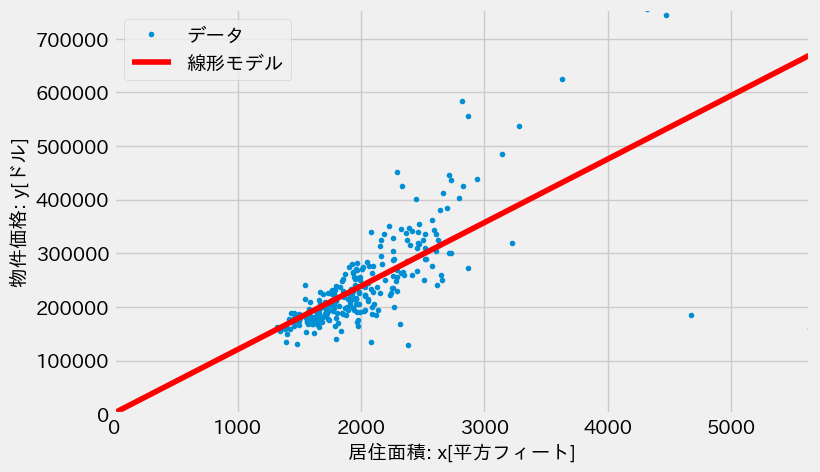

In [10]:
dataType = 1
model.plotResult(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,fName=f"../results/linearRegression_result_train_{dataType}.pdf")

## 重回帰

In [11]:
# データの生成
# 物件価格 説明変数:居住面積
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[data['MSSubClass']==60][['GrLivArea','GarageArea','PoolArea','BedroomAbvGr','TotRmsAbvGrd']].values
Y = data[data['MSSubClass']==60][['SalePrice']].values
xLabel = ''
yLabel = '物件価格y[ドル]'

In [12]:
# データを訓練と評価用に分割
dtrNum = int(len(X)*0.9)    # 学習データ数

# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

In [13]:
model = linerRegression(X_train, y_train)
with Timer(prefix=f'data fit = {len(X_train)}'):
    model.train()

data fit = 269 0.001[s]


In [14]:
print(f'モデルパラメータ:\nw={model.w},\nb={model.b}')
print(f'平方平均二乗誤差={model.RMSE(X_test,y_test):.2f}ドル')
print(f'決定係数={model.R2(X_test, y_test):.2f}')

モデルパラメータ:
w=[[   79.50167069]
 [  114.96036936]
 [ -203.88107482]
 [-6538.73835696]
 [13845.46420449]],
b=[-72974.80553545]
平方平均二乗誤差=26214.28ドル
決定係数=0.74


In [15]:
# 標準化
X = (X-np.mean(X, axis=0)) / np.std(X, axis=0)
Y = (Y-np.mean(Y, axis=0)) / np.std(Y, axis=0)

In [16]:
# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

model = linerRegression(X_train, y_train)
with Timer(prefix=f'data fit = {len(X_train)}'):
    model.train()

data fit = 269 0.001[s]


In [17]:
print(f'モデルパラメータ:\nw={model.w},\nb={model.b}')
print(f'平方平均二乗誤差={model.RMSE(X_test,y_test):.2f}ドル')
print(f'決定係数={model.R2(X_test, y_test):.2f}')

モデルパラメータ:
w=[[ 0.47441157]
 [ 0.22221602]
 [-0.12198818]
 [-0.04026554]
 [ 0.21386601]],
b=[0.01178856]
平方平均二乗誤差=0.30ドル
決定係数=0.74


## 外れ値と正則化

In [18]:
# データの生成
# 物件価格 説明変数:居住面積
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[data['MSSubClass']==60][['GrLivArea']]
Y = data[data['MSSubClass']==60][['SalePrice']]

out_ind = Y[Y['SalePrice']>700000].index
out_data = Y[Y['SalePrice']>700000] - 700000
out_data_model = Y[Y['SalePrice']>700000]

Y[Y>700000] -= 700000 # 外れ値
xLabel = '居住面積: x[平方フィート]'
yLabel = '物件価格: y[ドル]'

Text(0, 0.5, '物件価格: y[ドル]')

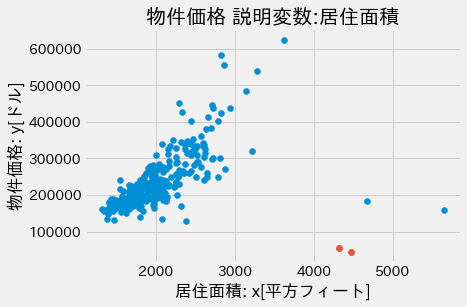

In [19]:
# データの可視化
plt.scatter(X, Y)
plt.scatter(X.loc[out_ind], out_data)

plt.title('物件価格 説明変数:居住面積')
plt.xlabel(xLabel)
plt.ylabel(yLabel)

In [20]:
# 外れ値なしデータ
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[data['MSSubClass']==60][['GrLivArea']]
Y = data[data['MSSubClass']==60][['SalePrice']]

# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

model = linerRegression(X_train, y_train)
with Timer(prefix=f'data fit = {len(X_train)}'):
    model.train()
    
# 線形モデルの直線の端点の座標を計算
Xlin_model = np.array([[0],[np.max(X)]])
Yplin_model = model.predict(Xlin_model)

data fit = 269 0.000[s]


In [21]:
# 外れ値ありのデータ
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[data['MSSubClass']==60][['GrLivArea']]
Y = data[data['MSSubClass']==60][['SalePrice']]

Y[Y>700000] -= 700000 # 外れ値
# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

out_model = linerRegression(X_train, y_train)
with Timer(prefix=f'data fit = {len(X_train)}'):
    out_model.train()

data fit = 269 0.000[s]


Text(0, 0.5, '物件価格: y[ドル]')

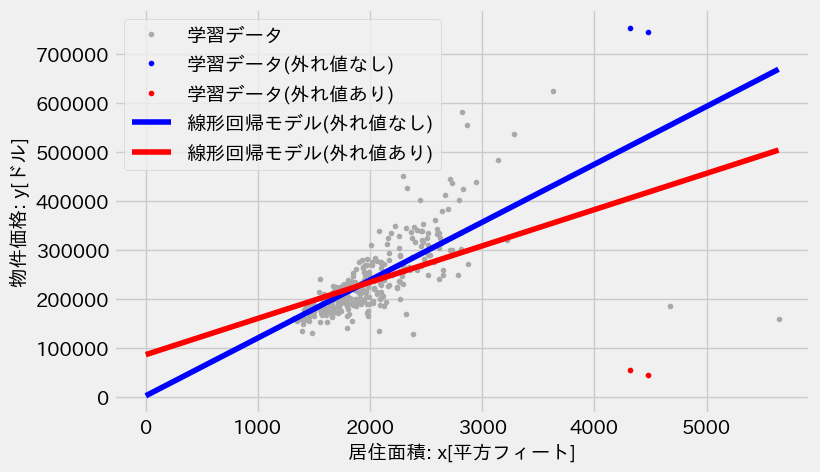

In [22]:
# データと線形モデルのプロット
fig = plt.figure(figsize=(8,5),dpi=100)

# 線形モデルの直線の端点の座標を計算
Xlin = np.array([[0],[np.max(X)]])
Yplin = out_model.predict(Xlin)

plt.plot(X,Y,'.', color='darkgray', label='学習データ')
plt.plot(X.loc[out_ind], out_data_model, '.', color='b', label='学習データ(外れ値なし)')
plt.plot(X.loc[out_ind], out_data, '.', color='r', label='学習データ(外れ値あり)')

plt.plot(Xlin_model,Yplin_model,'b',label='線形回帰モデル(外れ値なし)')
plt.plot(Xlin,Yplin,'r',label='線形回帰モデル(外れ値あり)')
plt.legend()

# 各軸の範囲とラベルの設定
# plt.ylim([0,np.max(Y.values)])
# plt.xlim([0,np.max(X.values)])
plt.xlabel(xLabel,fontSize=14)
plt.ylabel(yLabel,fontSize=14)

data fit = 269 0.000[s]


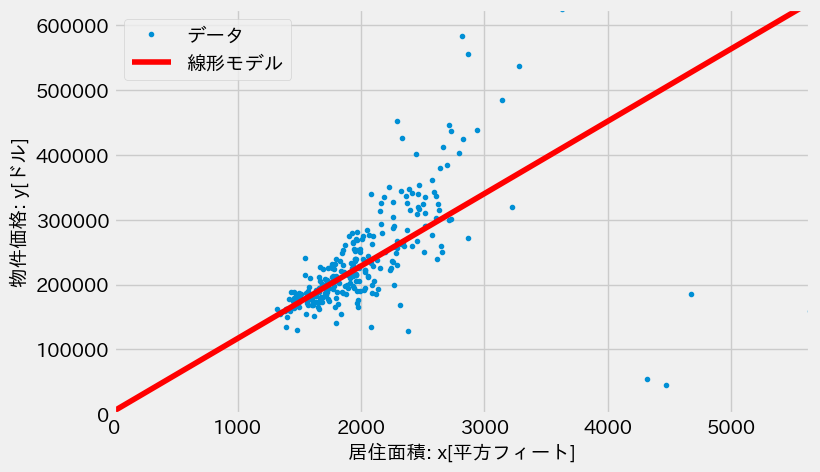

In [23]:
# 正則化あり
# 外れ値ありのデータ
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[data['MSSubClass']==60][['GrLivArea']].values
Y = data[data['MSSubClass']==60][['SalePrice']].values

Y[Y>700000] -= 700000 # 外れ値
# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

model = linerRegression(X_train, y_train)
with Timer(prefix=f'data fit = {len(X_train)}'):
    model.trainRegularized(lamb=1)

dataType = 3
model.plotResult(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,fName=f"../results/linearRegression_result_train_{dataType}.pdf")